
# Import Libraries

In [333]:
import numpy as np
import pandas as pd
import zipfile
import os
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True

In [334]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from matplotlib import cm
import matplotlib.pyplot as plt
pio.templates.default = 'gridon'

In [335]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder  , QuantileTransformer ,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,auc ,roc_auc_score , confusion_matrix
from sklearn.svm import SVC
from scipy import stats

import optuna
from xgboost import XGBClassifier

## Read Data

In [336]:
def unzip_file_to_same_location(zip_path):

    extract_to = os.path.dirname(zip_path)
 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
       
        zip_ref.extractall(extract_to)
        print('Extraction Complete')

In [337]:
zip_file_path = 'spaceship-titanic.zip'
unzip_file_to_same_location(zip_file_path)

Extraction Complete


In [338]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [339]:
df = pd.concat([df_train,df_test],axis=0).reset_index(drop=True)

# EDA

### 1. Analysing Missing Values

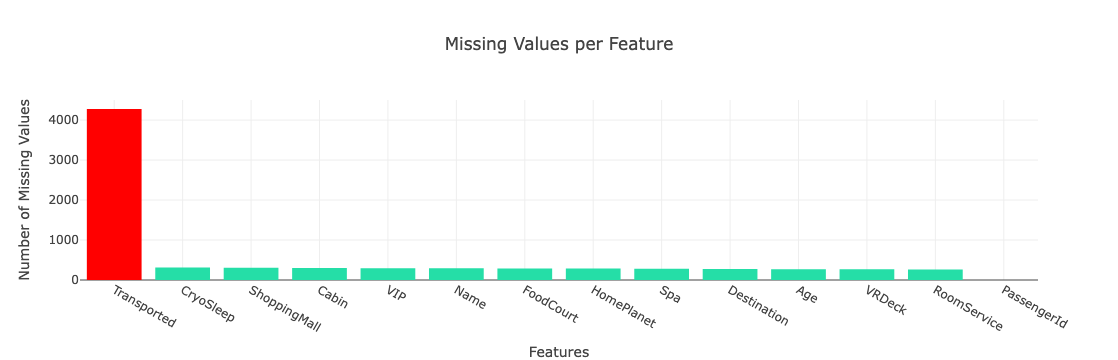

In [340]:

missing_values = df.isna().sum().sort_values(ascending=False)

colors = ['#ff0000'] + ['#25dea7'] * (len(missing_values) - 1)  


fig = go.Figure(go.Bar(
    x=missing_values.index, 
    y=missing_values.values,  
    marker_color=colors ,hoverinfo='none' 
))


fig.update_layout(
    title='Missing Values per Feature',
    xaxis_title='Features',
    yaxis_title='Number of Missing Values',
    plot_bgcolor='white'
)

# Show plot
fig.show()

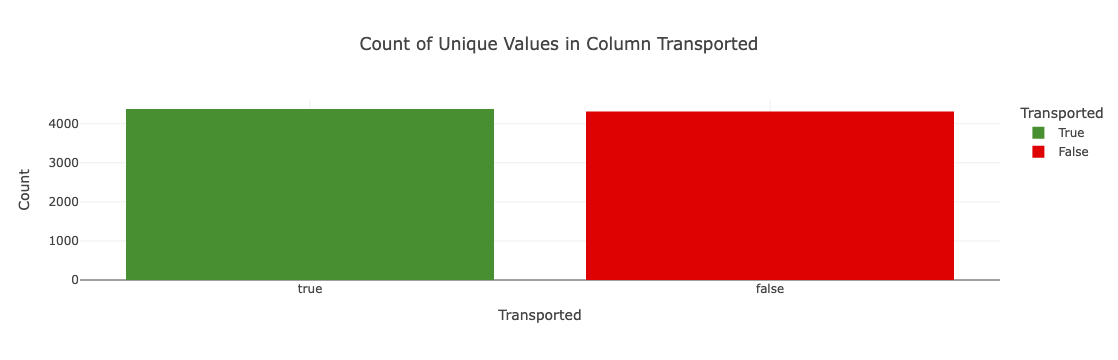

In [341]:
column_to_plot = 'Transported'
value_counts = df[column_to_plot].value_counts().reset_index()
value_counts.columns = [column_to_plot, 'Count']


color_map = {
    True: '#488f31',  
    False: '#de0202'  
}

fig = px.bar(
    value_counts,
    x=column_to_plot,
    y='Count',
    title=f'Count of Unique Values in Column {column_to_plot}',
    color=column_to_plot,
    color_discrete_map=color_map  
)

fig.update_layout(
    legend_title_text='Transported'
)

fig.show()

### 2. Split the Name in First Name and Last Name

In [342]:
df[['FirstName', 'LastName']] = df['Name'].str.split(' ', expand=True)
df.drop('Name',axis=1,inplace=True)


### 3. Split the Cabin in Deck, Number and Side

In [343]:
df[['Deck', 'Num','Side']] = df['Cabin'].str.split('/', expand=True)
df.drop('Cabin',axis=1,inplace=True)

### 4. The passender Id will be later used to identinfy where there were families travelling together or not

In [344]:
df[['SurnameMap', 'SeatNumber']] = df['PassengerId'].str.split('_', expand=True)
df.drop('PassengerId',inplace=True,axis=1)
df['SurnameMap'] = df['SurnameMap'].astype(str)
df['SeatNumber'] = df['SeatNumber'].astype(int)

### 5. Analysing missing data

#### There were some values missing in Deck column. A member with missing deck was considered as staff if CryoSleep was true and services were 0. Also, they were not VIP's.

In [345]:
staff_index =  (df['Deck'].isna()) & (df['CryoSleep']==True)


In [346]:
df[staff_index].describe()

Age  RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  \
count  118.000000        117.0      117.0         116.0  117.0   118.0   
mean    28.169492          0.0        0.0           0.0    0.0     0.0   
std     15.736780          0.0        0.0           0.0    0.0     0.0   
min      0.000000          0.0        0.0           0.0    0.0     0.0   
25%     17.250000          0.0        0.0           0.0    0.0     0.0   
50%     25.500000          0.0        0.0           0.0    0.0     0.0   
75%     37.000000          0.0        0.0           0.0    0.0     0.0   
max     75.000000          0.0        0.0           0.0    0.0     0.0   

       SeatNumber  
count  119.000000  
mean     1.521008  
std      0.981600  
min      1.000000  
25%      1.000000  
50%      1.000000  
75%      2.000000  
max      7.000000

In [347]:
df.loc[staff_index,'Side']='Staff'

#### If there were any servicies missing for staff. They were imputed with values 0.

In [348]:
service_missing = df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']].isna().any(axis=1)
df.loc[staff_index & service_missing,['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']] = 0.0

#### If VIP's were missing values for staff they were imputed with False values

In [349]:
vip_missing = df[['VIP']].isna().any(axis=1)
df.loc[staff_index & vip_missing,'VIP'] =False

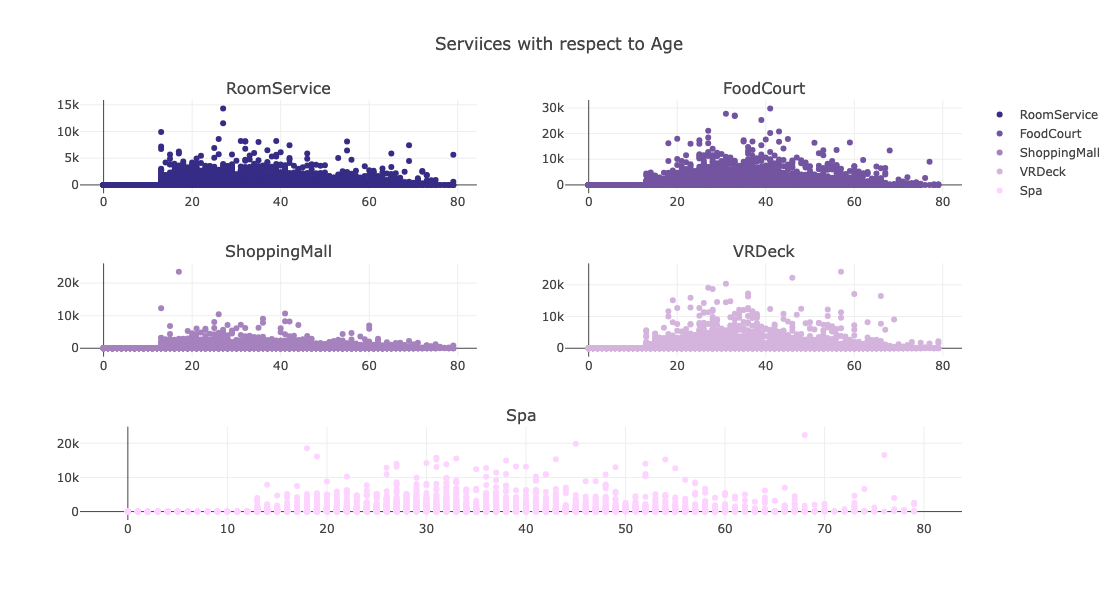

In [350]:


fig = make_subplots(rows=3, cols=2, subplot_titles=("RoomService", "FoodCourt", "ShoppingMall", "VRDeck","Spa"), specs=[[{}, {}], [{}, {}], [{"colspan": 2}, None]])


fig.add_trace(
    go.Scatter(x=df['Age'], y=df['RoomService'], mode='markers', name='RoomService',line=dict(color='#362c85')),
    row=1, col=1
)


fig.add_trace(
    go.Scatter(x=df['Age'], y=df['FoodCourt'], mode='markers', name='FoodCourt',line=dict(color='#7254a0')),
    row=1, col=2
)


fig.add_trace(
    go.Scatter(x=df['Age'], y=df['ShoppingMall'], mode='markers', name='ShoppingMall',line=dict(color='#a582bd')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df['Age'], y=df['VRDeck'], mode='markers', name='VRDeck',line=dict(color='#d4b3dd')),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=df['Age'], y=df['Spa'], mode='markers', name='Spa',line=dict(color='#fdd3ff')),
    row=3, col=1
)
fig.update_layout(
    height=600, width=1000, title_text="Serviices with respect to Age"
)

# Show the plot
fig.show()


#### From above plot we see that all services upto age 13 were having values 0.

In [351]:
toddler = df['Age']<13
df.loc[toddler & service_missing,['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']] =0.0

Similary all below age 13 were not VIP's

In [352]:
df[toddler]['VIP'].value_counts()

VIP
False    1129
Name: count, dtype: int64

In [353]:
df.loc[toddler & vip_missing,'VIP'] = False

#### We will create a column named gender based on names and then drop FirstName column.

In [354]:
d = gender.Detector()


def get_gender(name):
    if pd.isna(name):
        return 'Unknown'
    gender = d.get_gender(name)
    if gender in ['male', 'mostly_male']:
        return 'Male'
    elif gender in ['female', 'mostly_female']:
        return 'Female'
    else:
        return 'Unknown'


df['Gender'] = df['FirstName'].apply(get_gender)
df.drop('FirstName',inplace=True,axis=1)

#### We will now see a pair plot based on CryoSleep

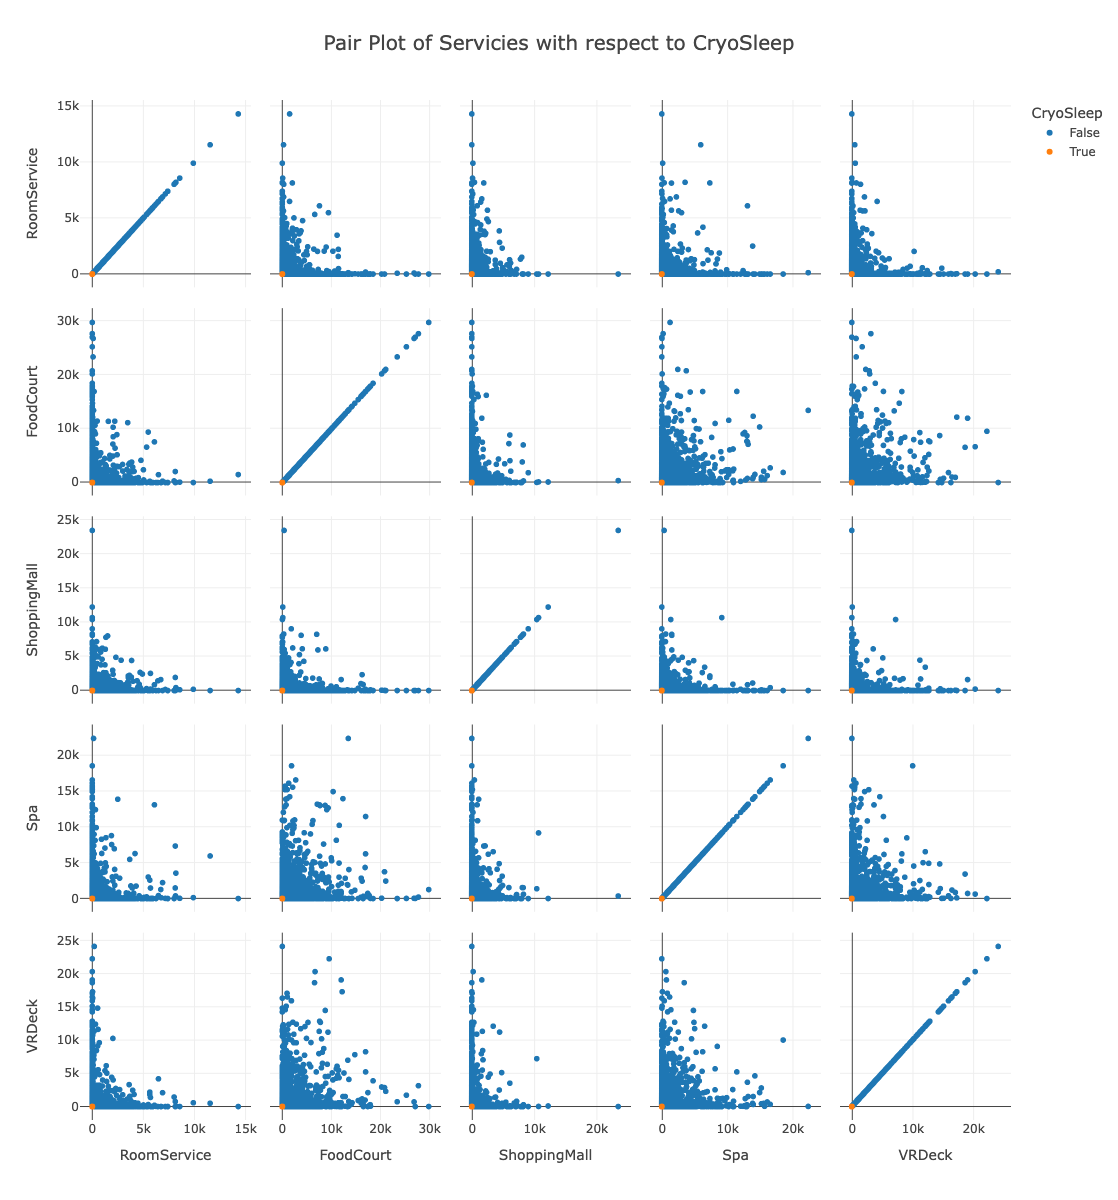

In [355]:

fig = px.scatter_matrix(df,
    dimensions=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    color='CryoSleep', 
    title='Pair Plot of Servicies with respect to CryoSleep',
    labels={col: col.replace('_', ' ') for col in df.columns} 
)

fig.update_layout(
    height=1200, 
    width=1000,  
    title_font_size=20, 
)


fig.show()

#### From the plot above we see that whereever CryoSleep was True, customers or staff did not pay for any sservices

In [356]:
sleep = (df['CryoSleep']==True)
df.loc[service_missing & sleep,['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']]=0.0

## 6. Most popular travelling routes

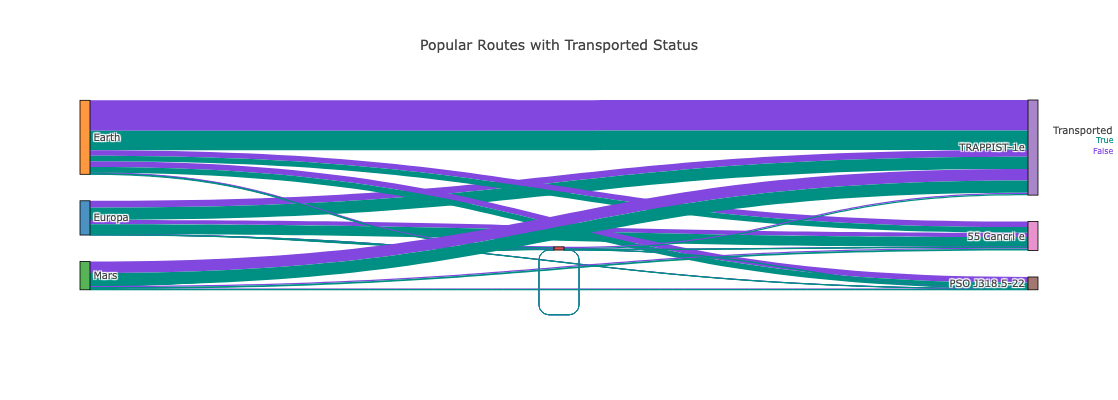

In [357]:
labels = list(pd.concat([df['HomePlanet'], df['Destination']]).unique())

label_dict = {label: i for i, label in enumerate(labels)}

df['Source'] = df['HomePlanet'].map(label_dict)
df['Target'] = df['Destination'].map(label_dict)

grouped = df.groupby(['Source', 'Target', 'Transported']).size().reset_index(name='Count')

color_map = {True: '#008f83', False: '#8147de'}
grouped['Color'] = grouped['Transported'].map(color_map)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=10,
        line=dict(color='black', width=.8),
        label=labels
    ),
    link=dict(
        source=grouped['Source'],
        target=grouped['Target'],
        value=grouped['Count'],
         color=grouped['Color'],  
        
    )
)])

fig.update_layout(title_text="Popular Routes with Transported Status", font_size=10,width=1100,
    height=400,annotations=[
        dict(
            x=1.08,
            y=0.9,
            xref='paper',
            yref='paper',
            showarrow=False,
            text='Transported',
            font=dict(size=10)
        ),
        dict(
            x=1.08,
            y=0.85,
            xref='paper',
            yref='paper',
            showarrow=False,
            text='<span style="color:#008f83">True</span>',
            font=dict(size=8)
        ),
        dict(
            x=1.08,
            y=0.8,
            xref='paper',
            yref='paper',
            showarrow=False,
            text='<span style="color:#8147de">False</span>',
            font=dict(size=8)
        )
    ])
fig.show()

In [358]:
df.groupby(['HomePlanet','Destination'])['VIP'].value_counts().reset_index()

HomePlanet    Destination    VIP  count
0       Earth    55 Cancri e  False    959
1       Earth  PSO J318.5-22  False   1044
2       Earth    TRAPPIST-1e  False   4588
3      Europa    55 Cancri e  False   1195
4      Europa    55 Cancri e   True     83
5      Europa  PSO J318.5-22  False     16
6      Europa  PSO J318.5-22   True     13
7      Europa    TRAPPIST-1e  False   1619
8      Europa    TRAPPIST-1e   True     78
9        Mars    55 Cancri e  False    291
10       Mars  PSO J318.5-22  False     55
11       Mars  PSO J318.5-22   True      9
12       Mars    TRAPPIST-1e  False   2126
13       Mars    TRAPPIST-1e   True     81

#### There were no VIP seats from Earth , and from Mars to 55 Cancri e.

In [359]:
df.loc[((df['HomePlanet']=='Earth') & (df['VIP'].isna())) ,'VIP'] =False

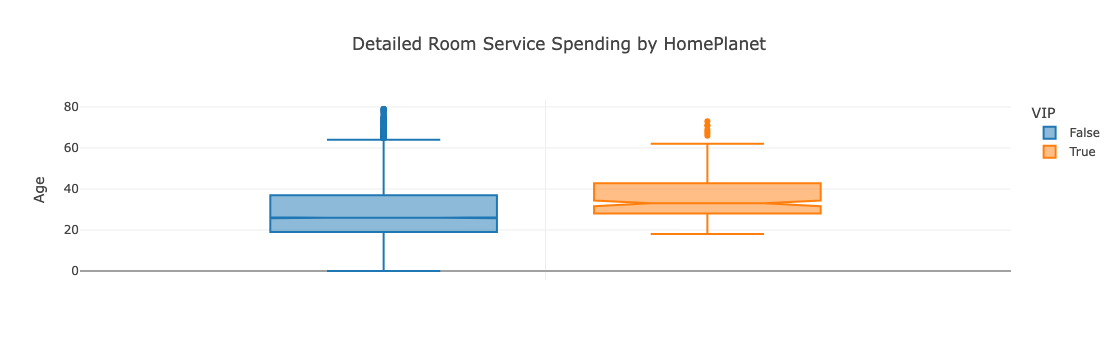

In [360]:
fig = px.box(df, y='Age', color='VIP',  
             notched=True, 
             title='Detailed Room Service Spending by HomePlanet')
fig.show()

#### From the plot above. We see that there were no VIP's below age of 18.

In [361]:
df.loc[((df['Age']<18) & (df['VIP'].isna())) ,'VIP'] = False

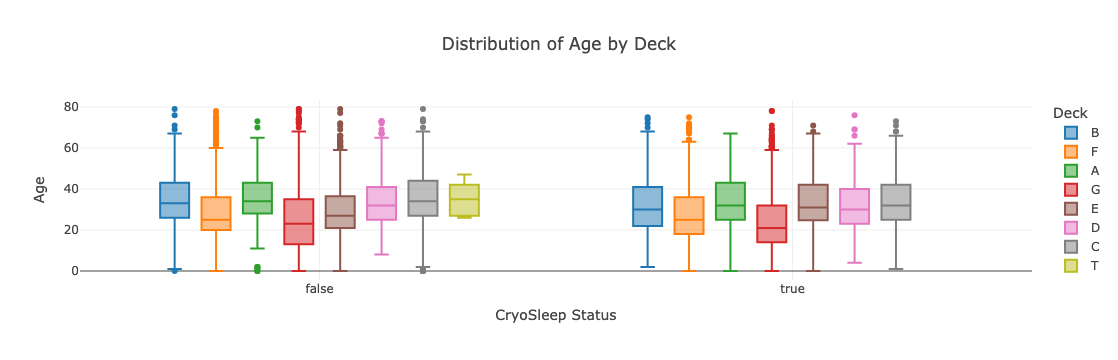

In [362]:
fig = px.box(
    df,
    x='CryoSleep',
    y='Age',
  color='Deck',
    labels={'CryoSleep': 'CryoSleep Status', 'Age': 'Age'},
    title='Distribution of Age by Deck'
)


fig.show()

#### From the plot above we see that there deck T was available only for CryoSleep false values

In [363]:
df.loc[(df['Deck']=='T') & (df['CryoSleep'].isna()),'CryoSleep'] = False

#### Family definition. The members are considered as Family if they have same LastName, First section of passenger ID and travelling from same location to destination. 

In [364]:
grouped =  df.groupby(['SurnameMap','LastName','Destination','HomePlanet'])['LastName'].count()

filtered = grouped[grouped > 1].sort_values(ascending=False).reset_index(name='FamilySize')
surname_to_lastname = filtered.set_index('LastName')['SurnameMap'].to_dict()

merged_df = pd.merge(df, filtered, on=['SurnameMap', 'LastName','Destination'], how='left')


merged_df['FamilyCount'] = merged_df['FamilySize'].fillna(1).astype(int)

df['FamilyCount'] = merged_df['FamilyCount'] 

#### Imputing missing values based on their probability of appearance in each columns.

In [365]:
print(df['HomePlanet'].value_counts(normalize=True))
missing_indices = df['HomePlanet'].isna()

random_values = np.random.choice(['Earth', 'Europa','Mars'], size=missing_indices.sum(),p=[0.54, 0.25,0.21])

df.loc[missing_indices, 'HomePlanet'] = random_values




print(df['Destination'].value_counts(normalize=True))
missing_indices = df['Destination'].isna()

random_values = np.random.choice(['TRAPPIST-1e', '55 Cancri e','PSO J318.5-22'], size=missing_indices.sum(),p=[0.7, 0.21,0.09])

df.loc[missing_indices, 'Destination'] = random_values

HomePlanet
Earth     0.541318
Europa    0.247043
Mars      0.211639
Name: proportion, dtype: float64
Destination
TRAPPIST-1e      0.698724
55 Cancri e      0.208018
PSO J318.5-22    0.093258
Name: proportion, dtype: float64


#### Imputing services by median.

In [366]:
columns_to_impute = ['RoomService'	,'FoodCourt'	,'ShoppingMall',	'Spa',	'VRDeck']

In [367]:
for column in columns_to_impute:
    if column in df.columns:
        median_value = round(df[column].median())
        
        df[column] = df[column].fillna(median_value)

In [368]:
print(df['CryoSleep'].value_counts(normalize=True))
missing_indices = df['CryoSleep'].isna()

random_values = np.random.choice([False,True], size=missing_indices.sum(),p=[0.63, .37])

df.loc[missing_indices, 'CryoSleep'] = random_values

CryoSleep
False    0.63818
True     0.36182
Name: proportion, dtype: float64


In [369]:
df['Age'] = df['Age'].fillna(round(df['Age'].median()))

In [370]:
df['VIP'].value_counts(normalize=True)
missing_indices = df['VIP'].isna()

random_values = np.random.choice([False,True], size=missing_indices.sum(),p=[0.97, .03])

df.loc[missing_indices, 'VIP'] = random_values

In [371]:
print(df['Side'].value_counts(normalize=True))
missing_indices = df['Side'].isna()

random_values = np.random.choice(['S','P'], size=missing_indices.sum(),p=[0.5, .5])

df.loc[missing_indices, 'Side'] = random_values

Side
S        0.498905
P        0.491790
Staff    0.009304
Name: proportion, dtype: float64


#### Creating a Family column.

In [372]:
def categorize_family(count):
    if count == 1:
        return 'Individual'
    elif count == 2:
        return 'Couple'
    elif 3 <= count <= 4:
        return 'Family'
    else:
        return 'Joint Family'

df['IsFamily'] = df['FamilyCount'].apply(categorize_family)

#### Classification based on age.

In [373]:

bins = [0,  12,  35, 60,  100]
labels = ['Child', 'Young_Adult', 'Adult', 'Old']

df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [374]:
print(df['Deck'].value_counts(normalize=True))
missing_indices = df['Deck'].isna()

random_values = np.random.choice(['F','G','E','B','C','D','A'], size=missing_indices.sum(),p=[0.33,0.3,0.1,.1,0.09,0.05,0.03])

df.loc[missing_indices, 'Deck'] = random_values

Deck
F    0.334543
G    0.298398
E    0.104412
B    0.090048
C    0.086970
D    0.056823
A    0.027938
T    0.000868
Name: proportion, dtype: float64


In [375]:
df['totalspent'] = df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
columns_to_divide = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'totalspent']


df[columns_to_divide] = df[columns_to_divide].div(df['FamilyCount'], axis=0)

In [376]:
df.drop(['LastName','Num','Deck','SurnameMap','SurnameMap','SeatNumber','Target','Source'],axis=1,inplace=True)

In [377]:
df.isna().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Side               0
Gender             0
FamilyCount        0
IsFamily           0
AgeGroup           0
totalspent         0
dtype: int64

### 7. ML Models

In [378]:


def train_and_evaluate_classifiers(df, target_col, classifiers=None):
   
    df_train = df[~df[target_col].isna()]
    df_test = df[df[target_col].isna()]

    X_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col].astype('int')

  
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

  
    numerical_features = ['Age']  
    other_numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.difference(numerical_features).tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

  
    preprocessor = ColumnTransformer(
        transformers=[
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'), numerical_features),
            ('num', QuantileTransformer(output_distribution='normal'), other_numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ])

   
    if classifiers is None:
        classifiers = [
            ('Logistic Regression', LogisticRegression()),
            ('Random Forest', RandomForestClassifier(random_state=42)),
            ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
            ('AdaBoost', AdaBoostClassifier(random_state=42)),
            ('SVM', SVC(probability=True)),
            ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
        ]

   
    results = {}
    for name, model in classifiers:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
       
        print(f"{name} Accuracy: {accuracy:.5f}")

    return results




In [379]:
results = train_and_evaluate_classifiers(df, 'Transported')

Logistic Regression Accuracy: 0.74847
Random Forest Accuracy: 0.78604
Gradient Boosting Accuracy: 0.79831
AdaBoost Accuracy: 0.78719
SVM Accuracy: 0.76725
XGBoost Accuracy: 0.79410


In [380]:
def create_pipeline(df, target_col,model_name):
    print("Pipeline in process")
    df_train = df[~df[target_col].isna()]
    df_test = df[df[target_col].isna()]

    X_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col].astype('int')
    X_final_test = df_test.drop(target_col, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
    )

    numerical_features = ['Age']
    other_numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.difference(numerical_features).tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'bool','category']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'), numerical_features),
            ('num', QuantileTransformer(output_distribution='normal'), other_numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), categorical_features)
        ])

    if model_name =='XGBoost':
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('classifier', XGBClassifier())])
        
    if model_name =='GradientBoost':
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier())])
    if model_name =='Adaboost':
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier())])

    
   


    print("Pipeline process completed")
    return pipeline, X_train, X_test, y_train, y_test, X_final_test

In [381]:
def objective(trial, preprocessor,X_train, y_train, X_test, y_test,model_name):
    if model_name =='XGBoost':
        param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'eval_metric': trial.suggest_categorical('eval_metric', ['logloss', 'auc','mlogloss']),
        'n_jobs': -1 
    }
        model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**param))])
    if model_name =='GradientBoost':
        param = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.05)
    }
        model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(**param))])
    
    if model_name == 'Adaboost':
        
        param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']) 
    }

 
        
        model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(**param))])
        
   

        

    
    model.fit(X_train, y_train)

    
    y_test_pred = model.predict(X_test)

  
    acc = accuracy_score(y_test, y_test_pred)

  

    
    return acc
    
    

In [383]:
def optimizer(preprocessor,X_train, y_train, X_test, y_test,model_name):
    print("Hyperparameter tuning has begun")
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction='maximize',sampler=sampler)
    study.optimize(lambda trial: objective(trial,preprocessor, X_train, y_train, X_test, y_test,model_name), n_trials=100)
    print("Hyperparameter tuning has ended")

    print(f"Best Accuracu Score: {study.best_trial.value}")
    print(f"Best Parameters: {study.best_trial.params}")
    return study.best_trial.params

In [385]:
pipeline, X_train, X_test, y_train, y_test, X_final_test = create_pipeline(df, 'Transported','XGBoost')
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(confusion_matrix(y_test, y_pred))
preprocessor = pipeline.named_steps['preprocessor']
best_params_xg = optimizer(preprocessor,X_train, y_train, X_test, y_test,'XGBoost')

Pipeline in process
Pipeline process completed


[I 2024-08-20 22:02:30,295] A new study created in memory with name: no-name-eedf4099-b560-4d73-8557-6ccb4b30694e
[I 2024-08-20 22:02:30,370] Trial 0 finished with value: 0.5322085889570553 and parameters: {'booster': 'gblinear', 'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.015607892088416904, 'subsample': 0.24646688973455957, 'colsample_bytree': 0.8929409166199482, 'colsample_bylevel': 0.6808920093945671, 'colsample_bynode': 0.7664580622368364, 'gamma': 0.3087674144370367, 'min_child_weight': 10, 'reg_alpha': 0.04566054873446117, 'reg_lambda': 4.997040685255803e-07, 'scale_pos_weight': 2.636424704863906, 'max_delta_step': 2, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.5322085889570553.
[I 2024-08-20 22:02:30,433] Trial 1 finished with value: 0.5038343558282209 and parameters: {'booster': 'gblinear', 'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.045612437721861424, 'subsample': 0.8281407691144109, 'colsample_bytree': 0.3597390257266878, 'colsample_bylevel':

Test Accuracy: 0.7941
[[1021  274]
 [ 263 1050]]
Hyperparameter tuning has begun


[I 2024-08-20 22:02:30,533] Trial 2 finished with value: 0.6096625766871165 and parameters: {'booster': 'gbtree', 'n_estimators': 104, 'max_depth': 3, 'learning_rate': 0.09093294700385743, 'subsample': 0.40702398528001354, 'colsample_bytree': 0.7300178274831857, 'colsample_bylevel': 0.4493688608715288, 'colsample_bynode': 0.6160544169422487, 'gamma': 8.200654190149194, 'min_child_weight': 2, 'reg_alpha': 0.5710537951126796, 'reg_lambda': 0.015887756931672537, 'scale_pos_weight': 9.455490474077703, 'max_delta_step': 9, 'eval_metric': 'auc'}. Best is trial 2 with value: 0.6096625766871165.
[I 2024-08-20 22:02:31,773] Trial 3 finished with value: 0.6196319018404908 and parameters: {'booster': 'dart', 'n_estimators': 84, 'max_depth': 4, 'learning_rate': 0.08287546354010142, 'subsample': 0.4854026613548714, 'colsample_bytree': 0.4247476077499046, 'colsample_bylevel': 0.6341568665265989, 'colsample_bynode': 0.31273937997981016, 'gamma': 12.032954711310595, 'min_child_weight': 1, 'reg_alpha':

Hyperparameter tuning has ended
Best Accuracu Score: 0.8040644171779141
Best Parameters: {'booster': 'gbtree', 'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.09230597642589286, 'subsample': 0.3877461177867335, 'colsample_bytree': 0.9715809864980387, 'colsample_bylevel': 0.8389283649834078, 'colsample_bynode': 0.44577434839280783, 'gamma': 5.175666497139147, 'min_child_weight': 9, 'reg_alpha': 5.458930355923554e-07, 'reg_lambda': 0.19915656418774952, 'scale_pos_weight': 1.3600944880496066, 'max_delta_step': 3, 'eval_metric': 'mlogloss'}


In [386]:
pipeline, X_train, X_test, y_train, y_test, X_final_test = create_pipeline(df, 'Transported','Adaboost')
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(confusion_matrix(y_test, y_pred))
preprocessor = pipeline.named_steps['preprocessor']
best_params_ada = optimizer(preprocessor,X_train, y_train, X_test, y_test,'Adaboost')

Pipeline in process
Pipeline process completed


[I 2024-08-20 22:05:42,340] A new study created in memory with name: no-name-caa85792-bb96-4218-bf98-22e3efd8826d


Test Accuracy: 0.7872
[[ 974  321]
 [ 234 1079]]
Hyperparameter tuning has begun


[I 2024-08-20 22:05:42,930] Trial 0 finished with value: 0.7799079754601227 and parameters: {'n_estimators': 193, 'learning_rate': 0.951207163345817, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.7799079754601227.
[I 2024-08-20 22:05:43,231] Trial 1 finished with value: 0.7756901840490797 and parameters: {'n_estimators': 86, 'learning_rate': 0.16443457513284063, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.7799079754601227.
[I 2024-08-20 22:05:44,198] Trial 2 finished with value: 0.790260736196319 and parameters: {'n_estimators': 305, 'learning_rate': 0.710991852018085, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.790260736196319.
[I 2024-08-20 22:05:45,529] Trial 3 finished with value: 0.7891104294478528 and parameters: {'n_estimators': 418, 'learning_rate': 0.22021571957149338, 'algorithm': 'SAMME.R'}. Best is trial 2 with value: 0.790260736196319.
[I 2024-08-20 22:05:46,022] Trial 4 finished with value: 0.7749233128834356 and parameters: {'n_estimators': 1

Hyperparameter tuning has ended
Best Accuracu Score: 0.7937116564417178
Best Parameters: {'n_estimators': 267, 'learning_rate': 0.7879794949458565, 'algorithm': 'SAMME.R'}


In [387]:
pipeline, X_train, X_test, y_train, y_test, X_final_test = create_pipeline(df, 'Transported','GradientBoost')
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(confusion_matrix(y_test, y_pred))
preprocessor = pipeline.named_steps['preprocessor']
best_params_gb = optimizer(preprocessor,X_train, y_train, X_test, y_test,'GradientBoost')

Pipeline in process
Pipeline process completed


[I 2024-08-20 22:06:59,369] A new study created in memory with name: no-name-9edb9bec-4cd3-48e0-8de4-9bae67f995aa


Test Accuracy: 0.7987
[[ 999  296]
 [ 229 1084]]
Hyperparameter tuning has begun


[I 2024-08-20 22:06:59,733] Trial 0 finished with value: 0.7361963190184049 and parameters: {'loss': 'exponential', 'learning_rate': 0.14907884894416698, 'n_estimators': 140, 'subsample': 0.5780093202212182, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 9, 'min_impurity_decrease': 0.06011150117432088, 'max_features': 'sqrt', 'ccp_alpha': 0.04849549260809972}. Best is trial 0 with value: 0.7361963190184049.
[I 2024-08-20 22:06:59,897] Trial 1 finished with value: 0.7358128834355828 and parameters: {'loss': 'log_loss', 'learning_rate': 0.04454674376934912, 'n_estimators': 77, 'subsample': 0.6521211214797689, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 5, 'min_impurity_decrease': 0.06118528947223795, 'max_features': 'log2', 'ccp_alpha': 0.018318092164684587}. Best is trial 0 with value: 0.7361963190184049.
[I 2024-08-20 22:07:00,140] Trial 2 finished with value: 0.7377300613496932 and parameters: {'loss': 'exponential', 'learning_rate': 0.047938018610088354, 

Hyperparameter tuning has ended
Best Accuracu Score: 0.8021472392638037
Best Parameters: {'loss': 'exponential', 'learning_rate': 0.11862024540486779, 'n_estimators': 188, 'subsample': 0.7272551065970604, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 5, 'min_impurity_decrease': 0.07280253875666066, 'max_features': 'sqrt', 'ccp_alpha': 0.0005029391157804909}


In [388]:
def voting_classifiers(df, target_col,ada,gb,xg ,X_final_test,classifiers=None,threshold=0.5):
    df_train = df[~df[target_col].isna()]
    df_test = df[df[target_col].isna()]

    X_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col].astype('int')

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

    numerical_features = ['Age']  
    other_numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.difference(numerical_features).tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'), numerical_features),
            ('num', QuantileTransformer(output_distribution='normal'), other_numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ])
    
    ad_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(**ada,random_state=42))])
    gb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(**gb,random_state=42))])
    xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', XGBClassifier(**xg,random_state=42))])

    if classifiers is None:
        classifiers = [
            ('ada', ad_pipeline),
            ('gb', gb_pipeline),
            ('xgb', xgb_pipeline)
        ]

    voting_clf = VotingClassifier(estimators=classifiers, voting='soft')
    voting_clf.fit(X_train, y_train)
    
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of voting classifier: {accuracy:.4f}')


    
    y_final_test_prob = voting_clf.predict_proba(X_final_test)[:, 1]
    y_final_test_pred = (y_final_test_prob >= threshold).astype(bool)
    
    return y_final_test_pred , voting_clf
    
    


In [389]:
def save_predictions_to_csv(y_test, output_csv_name,input_csv='sample_submission.csv'):
    submission_df = pd.read_csv(input_csv)
    
    submission_df['Transported'] = y_test
    
    submission_df.to_csv(output_csv_name, index=False)
    print(f"Predictions saved to {output_csv_name}")

In [395]:
y_final_test_pred , voting_clf = voting_classifiers(df,'Transported',best_params_ada ,best_params_gb,best_params_xg,X_final_test,threshold=0.45)
save_predictions_to_csv(y_final_test_pred,'submission_0.45_seed.csv')
#best

Accuracy of voting classifier: 0.8006
Predictions saved to submission_0.45_seed.csv


In [56]:


def get_feature_importance_df(voting_clf):

    feature_importances = []
    feature_names = None


    for name, clf in voting_clf.named_estimators_.items():
        if hasattr(clf, 'named_steps') and 'classifier' in clf.named_steps and hasattr(clf.named_steps['classifier'], 'feature_importances_'):
            preprocessor = clf.named_steps['preprocessor']
            feature_names = get_feature_names(preprocessor)
            
            importances = clf.named_steps['classifier'].feature_importances_
            feature_importances.append(importances)

    mean_importances = np.mean(feature_importances, axis=0)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importance_df

def get_feature_names(preprocessor):
   
    feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)  

    return feature_names


In [57]:
def plot_feature_importance(importance_df):
  
    
    colors = px.colors.sequential.Blues  
    

    num_features = len(importance_df)

    if num_features > len(colors):
        cmap = cm.get_cmap('Blues', num_features)  
        selected_colors = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})' for c in cmap(np.linspace(0, 1, num_features))]
    else:
        selected_colors = colors[-num_features:]  

    selected_colors = selected_colors[::-1]
    
    fig = go.Figure()

    for i in range(num_features):
        fig.add_trace(go.Bar(
            x=[importance_df.loc[i, 'Feature']],
            y=[importance_df.loc[i, 'Importance']],
            marker_color=selected_colors[i]
        ))

    fig.update_layout(
        title='Feature Importance',
        xaxis_title='Feature',
        yaxis_title='Importance',
        width=1000,
        height=600,
        showlegend=False
    )

    return fig

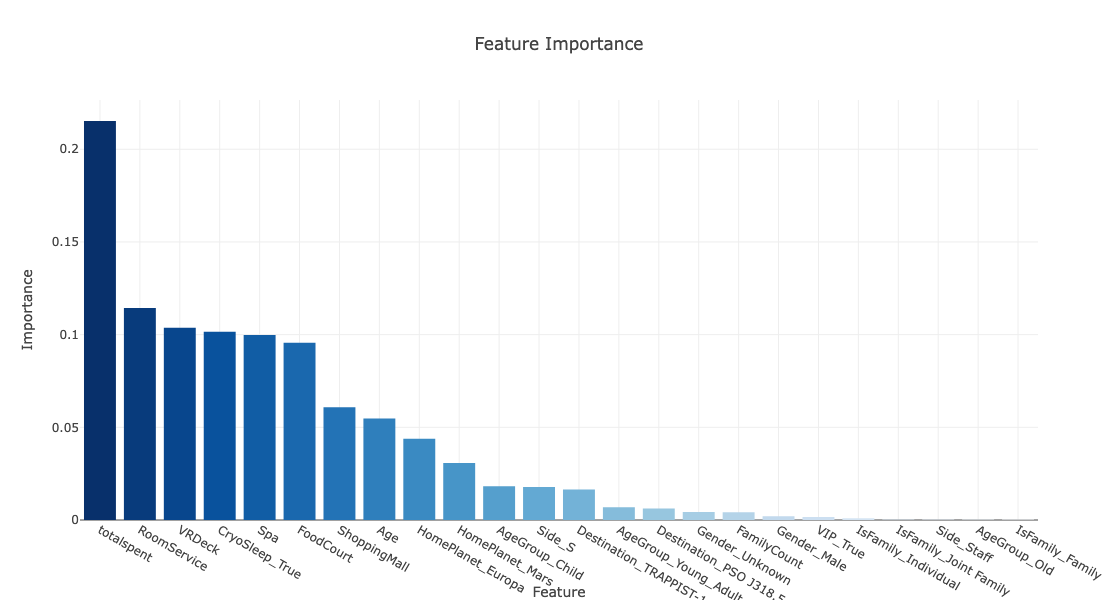

In [58]:
importance_df = get_feature_importance_df(voting_clf)
fig = plot_feature_importance(importance_df)
fig.show()